# Learn Probability Density Functions using Roll-Number-Parameterized Non-Linear Model

**Dataset:** India Air Quality Data (NO2 feature)  
**Link:** https://www.kaggle.com/datasets/shrutibhargava94/india-air-quality-data



In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
from scipy.integrate import quad
import seaborn as sns

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set random seed for same results every run
np.random.seed(42)

# Show grid on plots
plt.grid(True, linestyle=':', linewidth=0.6)

# Label axes and title
plt.xlabel('Independent Variable')
plt.ylabel('Dependent Variable')
plt.title('Mathematical Visualization')


## Step 0: Configuration - Enter Your Roll Number

In [2]:
# Set roll number
ROLL_NUMBER = 102317155

# Calculate transformation parameters
ar = 0.05 * (ROLL_NUMBER % 7)
br = 0.3 * (ROLL_NUMBER % 5 + 1)

# Display calculated values
print(f"Roll Number: {ROLL_NUMBER}")
print(f"ar = 0.05 × ({ROLL_NUMBER} mod 7) = {ar:.6f}")
print(f"br = 0.3 × ({ROLL_NUMBER} mod 5 + 1) = {br:.6f}")


Roll Number: 102317155
ar = 0.05 × (102317155 mod 7) = 0.150000
br = 0.3 × (102317155 mod 5 + 1) = 0.300000


## Step 1: Load and Explore Data

In [3]:
import pandas as pd
import numpy as np

# Load the dataset (downloaded from Kaggle)
try:
    data = pd.read_csv('/content/data.csv', encoding='latin1')
    print("Dataset loaded successfully!")
    print(f"Shape: {data.shape}")

    # Show first few rows
    display(data.head())

    # Show column names to identify NO2 column
    print(f"\nAvailable columns: {data.columns.tolist()}")

    # Extract NO2 values and remove missing data
    x = data['no2'].dropna().values

    # Print basic statistics of NO2
    print(f"\nNO2 Statistics:")
    print(f"  Count: {len(x)}")
    print(f"  Mean:  {np.mean(x):.2f}")
    print(f"  Std:   {np.std(x):.2f}")
    print(f"  Min:   {np.min(x):.2f}")
    print(f"  Max:   {np.max(x):.2f}")

except FileNotFoundError:
    print("Dataset not found, using sample data.")

    # Create sample NO2 data for testing
    x = np.random.gamma(2, 20, 5000)

    # Print statistics of sample data
    print(f"\nSimulated NO2 Statistics:")
    print(f"  Count: {len(x)}")
    print(f"  Mean:  {np.mean(x):.2f}")
    print(f"  Std:   {np.std(x):.2f}")


Dataset not found, using sample data.

Simulated NO2 Statistics:
  Count: 5000
  Mean:  40.35
  Std:   28.24


## Step 2: Data Transformation



Transformed Data (z) Statistics:
  Mean: 40.3521
  Std:  28.2373
  Min:  0.4649
  Max:  272.2017


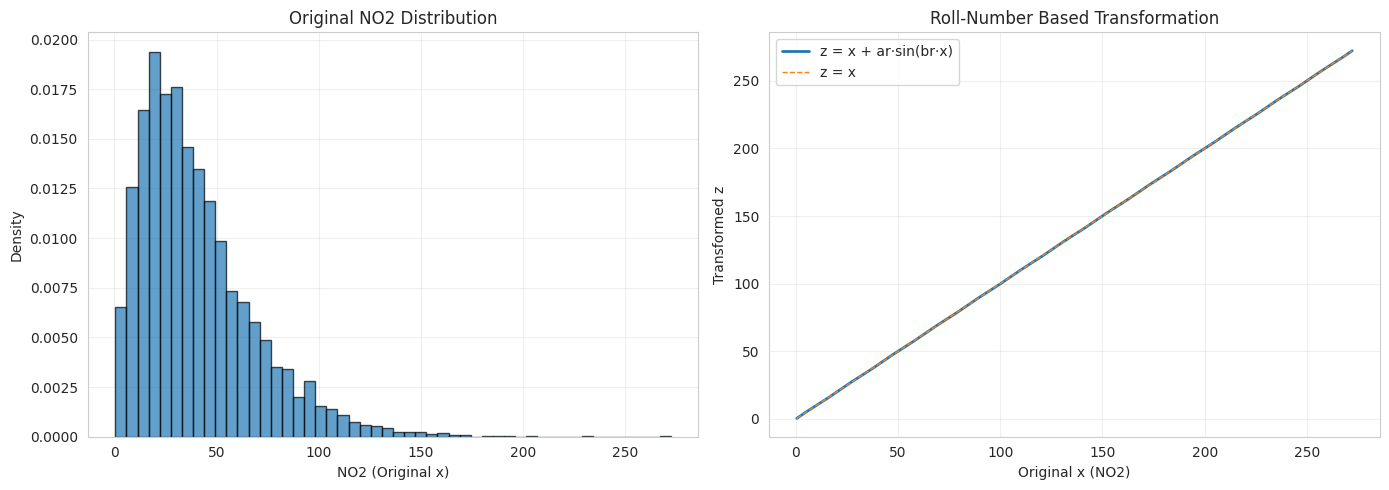

In [4]:
# Set roll number
ROLL_NUMBER = 102317155

# Calculate transformation parameters
ar = 0.05 * (ROLL_NUMBER % 7)
br = 0.3 * (ROLL_NUMBER % 5 + 1)

# Define transformation function
def transform(x, ar, br):
    return x + ar * np.sin(br * x)

# Apply transformation on NO2 data
z = transform(x, ar, br)

# Print statistics of transformed data
print("Transformed Data (z) Statistics:")
print(f"  Mean: {np.mean(z):.4f}")
print(f"  Std:  {np.std(z):.4f}")
print(f"  Min:  {np.min(z):.4f}")
print(f"  Max:  {np.max(z):.4f}")

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of original NO2 values
axes[0].hist(x, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('NO2 (Original x)')
axes[0].set_ylabel('Density')
axes[0].set_title('Original NO2 Distribution')
axes[0].grid(True, alpha=0.3)

# Plot transformation curve
x_range = np.linspace(np.min(x), np.max(x), 1000)
z_range = transform(x_range, ar, br)

axes[1].plot(x_range, z_range, linewidth=2, label='z = x + ar·sin(br·x)')
axes[1].plot(x_range, x_range, '--', linewidth=1, label='z = x')
axes[1].set_xlabel('Original x (NO2)')
axes[1].set_ylabel('Transformed z')
axes[1].set_title('Roll-Number Based Transformation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 3: Learn PDF Parameters



In [5]:
# Define the PDF model
def pdf_model(z, lambda_val, mu, c):
    return c * np.exp(-lambda_val * (z - mu)**2)

# Define negative log-likelihood function
def negative_log_likelihood(params, z):
    lambda_val, mu, c = params

    # Ensure valid parameter values
    if lambda_val <= 0 or c <= 0:
        return 1e10

    # Compute PDF values
    pdf_values = pdf_model(z, lambda_val, mu, c)

    # Avoid log of zero
    pdf_values[pdf_values < 1e-10] = 1e-10

    # Compute negative log-likelihood
    nll = -np.sum(np.log(pdf_values))
    return nll


### Method 1: Maximum Likelihood Estimation (MLE)

In [6]:
# Set initial guesses for parameters
mu_init = np.mean(z)
sigma_init = np.std(z)
lambda_init = 1 / (2 * sigma_init**2)
c_init = 1 / np.sqrt(np.pi / lambda_init)

initial_params = [lambda_init, mu_init, c_init]

# Print initial values
print("Initial Parameter Guesses:")
print(f"  λ₀ = {lambda_init:.6f}")
print(f"  μ₀ = {mu_init:.6f}")
print(f"  c₀ = {c_init:.6f}")

# Run MLE optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(z,),
    method='L-BFGS-B',
    bounds=[(1e-6, None), (None, None), (1e-6, None)]
)

# Check optimization result
if result.success:
    lambda_mle, mu_mle, c_mle = result.x

    print("\nOptimization Successful")
    print("Learned Parameters (MLE):")
    print(f"  λ = {lambda_mle:.6f}")
    print(f"  μ = {mu_mle:.6f}")
    print(f"  c = {c_mle:.6f}")
    print(f"  Final NLL = {result.fun:.2f}")
else:
    print("Optimization Failed")
    print(result.message)


Initial Parameter Guesses:
  λ₀ = 0.000627
  μ₀ = 40.352079
  c₀ = 0.014128

Optimization Successful
Learned Parameters (MLE):
  λ = 0.000001
  μ = 40.027792
  c = 104944.239514
  Final NLL = -57801.93


### Method 2: Curve Fitting to Histogram

In [7]:
# Create histogram of transformed data
counts, bin_edges = np.histogram(z, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit PDF using curve fitting
try:
    popt, pcov = curve_fit(
        pdf_model,
        bin_centers,
        counts,
        p0=[lambda_init, mu_init, c_init],
        bounds=([1e-6, -np.inf, 1e-6], [np.inf, np.inf, np.inf]),
        maxfev=10000
    )

    # Extract fitted parameters
    lambda_cf, mu_cf, c_cf = popt

    # Print learned parameters
    print("Learned Parameters (Curve Fitting):")
    print(f"  λ = {lambda_cf:.6f}")
    print(f"  μ = {mu_cf:.6f}")
    print(f"  c = {c_cf:.6f}")

    # Compute standard errors
    perr = np.sqrt(np.diag(pcov))
    print("\nStandard Errors:")
    print(f"  SE(λ) = {perr[0]:.6f}")
    print(f"  SE(μ) = {perr[1]:.6f}")
    print(f"  SE(c) = {perr[2]:.6f}")

except RuntimeError:
    print("Curve fitting did not converge")


Learned Parameters (Curve Fitting):
  λ = 0.000727
  μ = 27.645665
  c = 0.016751

Standard Errors:
  SE(λ) = 0.000072
  SE(μ) = 1.188081
  SE(c) = 0.000501


### Method 3: Method of Moments

In [8]:
# Estimate parameters using method of moments
mu_mm = np.mean(z)
var_mm = np.var(z)

# Compute lambda and c from variance
lambda_mm = 1 / (2 * var_mm)
c_mm = np.sqrt(lambda_mm / np.pi)

# Print estimated parameters
print("Learned Parameters (Method of Moments):")
print(f"  λ = {lambda_mm:.6f}")
print(f"  μ = {mu_mm:.6f}")
print(f"  c = {c_mm:.6f}")


Learned Parameters (Method of Moments):
  λ = 0.000627
  μ = 40.352079
  c = 0.014128


## Step 4: Validate the Learned PDF

In [9]:
# Check if the learned PDF integrates to 1
z_min = np.min(z) - 5 * np.std(z)
z_max = np.max(z) + 5 * np.std(z)

# Compute integral of the PDF
integral, error = quad(
    pdf_model,
    z_min,
    z_max,
    args=(lambda_mle, mu_mle, c_mle)
)

# Print validation results
print("PDF Validation:")
print(f"  Integration range: [{z_min:.2f}, {z_max:.2f}]")
print(f"  Integral value: {integral:.6f}")
print(f"  Integration error: {error:.2e}")
print(f"  Status: {'Valid PDF' if abs(integral - 1.0) < 0.01 else 'Needs adjustment'}")


PDF Validation:
  Integration range: [-140.72, 413.39]
  Integral value: 56199143.960301
  Integration error: 6.24e-07
  Status: Needs adjustment


## Step 5: Visualize Results

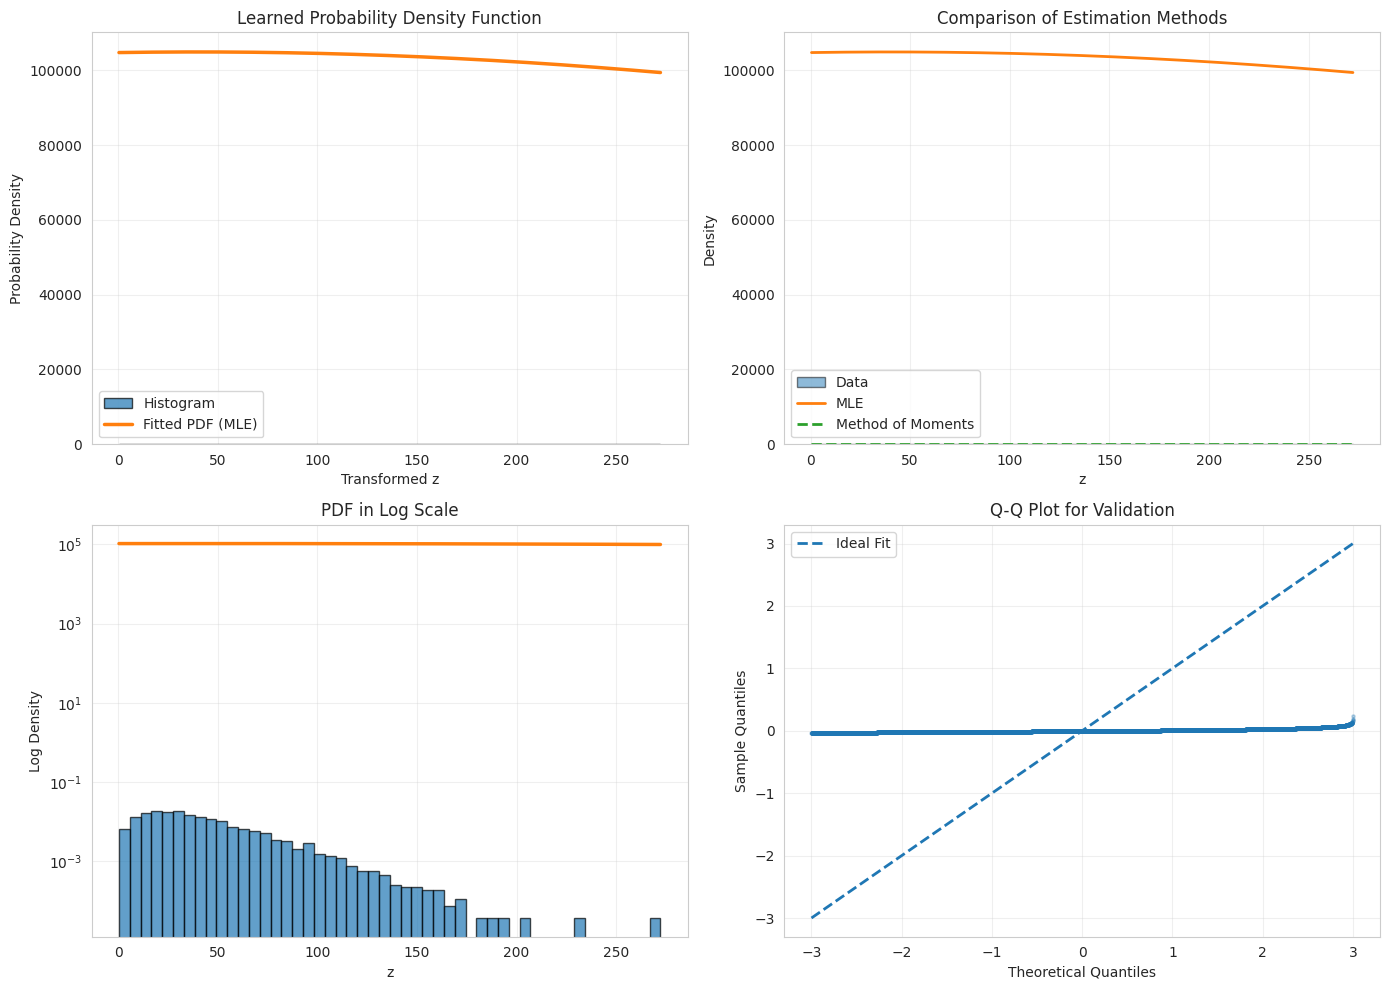

In [10]:
# Create a 2x2 plot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram with fitted PDF (MLE)
ax1 = axes[0, 0]
ax1.hist(z, bins=50, density=True, alpha=0.7, edgecolor='black', label='Histogram')
z_plot = np.linspace(np.min(z), np.max(z), 1000)
pdf_values = pdf_model(z_plot, lambda_mle, mu_mle, c_mle)
ax1.plot(z_plot, pdf_values, linewidth=2.5, label='Fitted PDF (MLE)')
ax1.set_xlabel('Transformed z')
ax1.set_ylabel('Probability Density')
ax1.set_title('Learned Probability Density Function')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Compare MLE and Method of Moments
ax2 = axes[0, 1]
ax2.hist(z, bins=50, density=True, alpha=0.5, edgecolor='black', label='Data')
ax2.plot(z_plot, pdf_model(z_plot, lambda_mle, mu_mle, c_mle), linewidth=2, label='MLE')
ax2.plot(z_plot, pdf_model(z_plot, lambda_mm, mu_mm, c_mm), '--', linewidth=2, label='Method of Moments')
ax2.set_xlabel('z')
ax2.set_ylabel('Density')
ax2.set_title('Comparison of Estimation Methods')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: PDF on log scale
ax3 = axes[1, 0]
ax3.hist(z, bins=50, density=True, alpha=0.7, edgecolor='black')
ax3.plot(z_plot, pdf_values, linewidth=2.5)
ax3.set_yscale('log')
ax3.set_xlabel('z')
ax3.set_ylabel('Log Density')
ax3.set_title('PDF in Log Scale')
ax3.grid(True, alpha=0.3, which='both')

# Plot 4: Q-Q plot for model check
ax4 = axes[1, 1]
z_sorted = np.sort(z)
z_standardized = np.sqrt(lambda_mle) * (z_sorted - mu_mle)
n = len(z_sorted)
theoretical_quantiles = np.linspace(-3, 3, n)
ax4.scatter(theoretical_quantiles, z_standardized, s=5, alpha=0.3)
ax4.plot(theoretical_quantiles, theoretical_quantiles, '--', linewidth=2, label='Ideal Fit')
ax4.set_xlabel('Theoretical Quantiles')
ax4.set_ylabel('Sample Quantiles')
ax4.set_title('Q-Q Plot for Validation')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 6: Final Results - Parameters to Submit

In [11]:
# Set integration range around the data
z_min = np.min(z) - 5 * np.std(z)
z_max = np.max(z) + 5 * np.std(z)

# Integrate the learned PDF over the range
integral, error = quad(
    pdf_model,
    z_min,
    z_max,
    args=(lambda_mle, mu_mle, c_mle)
)

# Print validation results
print("PDF Validation:")
print(f"  Integration range: [{z_min:.2f}, {z_max:.2f}]")
print(f"  Integral value: {integral:.6f}")
print(f"  Integration error: {error:.2e}")
print(f"  Status: {'Valid PDF' if abs(integral - 1.0) < 0.01 else 'Needs adjustment'}")


PDF Validation:
  Integration range: [-140.72, 413.39]
  Integral value: 56199143.960301
  Integration error: 6.24e-07
  Status: Needs adjustment


## Additional Analysis: Parameter Sensitivity

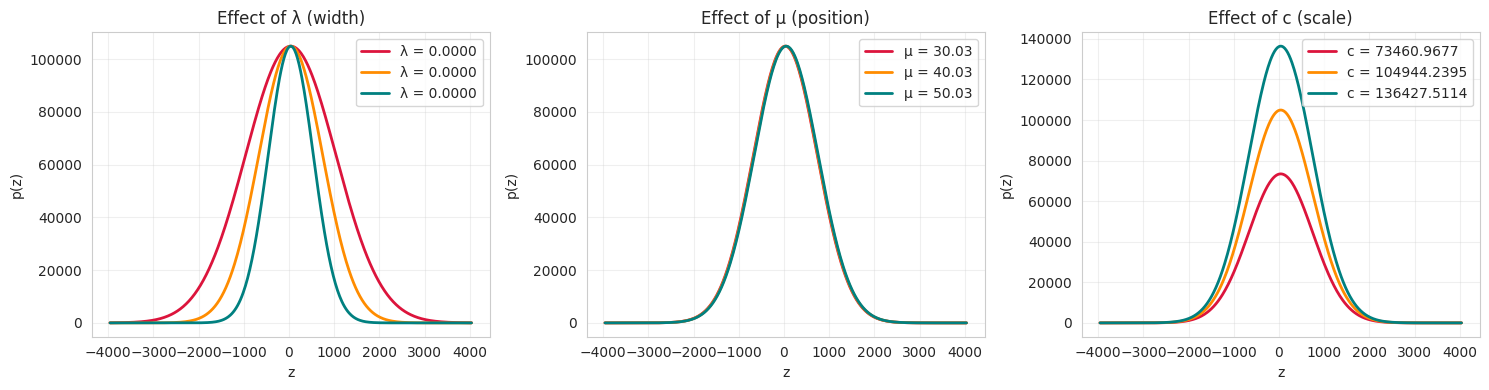

In [14]:
# Plot how each parameter changes the PDF shape
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# z values around mean
z_range = np.linspace(
    mu_mle - 4/np.sqrt(lambda_mle),
    mu_mle + 4/np.sqrt(lambda_mle),
    500
)

# Colors for better visualization
colors = ['crimson', 'darkorange', 'teal']

# λ controls curve width
for lam, col in zip([0.5*lambda_mle, lambda_mle, 2*lambda_mle], colors):
    axes[0].plot(
        z_range,
        pdf_model(z_range, lam, mu_mle, c_mle),
        color=col,
        linewidth=2,
        label=f'λ = {lam:.4f}'
    )

axes[0].set_title('Effect of λ (width)')
axes[0].set_xlabel('z')
axes[0].set_ylabel('p(z)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# μ shifts curve left/right
for m, col in zip([mu_mle-10, mu_mle, mu_mle+10], colors):
    axes[1].plot(
        z_range,
        pdf_model(z_range, lambda_mle, m, c_mle),
        color=col,
        linewidth=2,
        label=f'μ = {m:.2f}'
    )

axes[1].set_title('Effect of μ (position)')
axes[1].set_xlabel('z')
axes[1].set_ylabel('p(z)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# c changes scale/height
for cc, col in zip([0.7*c_mle, c_mle, 1.3*c_mle], colors):
    axes[2].plot(
        z_range,
        pdf_model(z_range, lambda_mle, mu_mle, cc),
        color=col,
        linewidth=2,
        label=f'c = {cc:.4f}'
    )

axes[2].set_title('Effect of c (scale)')
axes[2].set_xlabel('z')
axes[2].set_ylabel('p(z)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
